In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random

# 1. Loading the data

In [2]:
train_data, test_data = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train = train_data[0].reshape(-1,784).astype(float) / 255
y_train = train_data[1]

x_test = test_data[0].reshape(-1,784).astype(float) / 255
y_test = test_data[1]

x_test.shape

(10000, 784)

label is 9


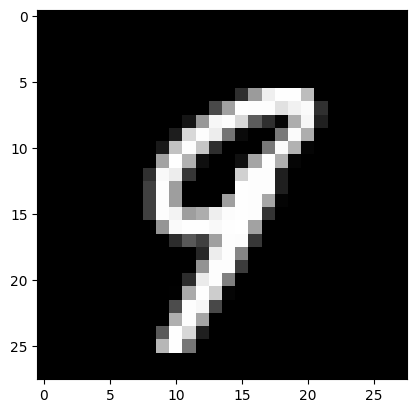

In [3]:
# exploring the data
i = np.random.randint(y_train.size)

print("label is", y_train[i])
plt.imshow(train_data[0][i], cmap='gray')

# 2. Building the model

We use Keras to build a fully-connected neural network.

For more details, see https://keras.io/guides/training_with_built_in_methods/

In [4]:
# source : https://keras.io/guides/training_with_built_in_methods/

def build_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(32, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
    return model

model = build_model()

loss = keras.losses.sparse_categorical_crossentropy


model.summary()


Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 784)]             0         
                                                                 
 dense_1 (Dense)             (None, 32)                25120     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 predictions (Dense)         (None, 10)                330       
                                                                 
Total params: 26506 (103.54 KB)
Trainable params: 26506 (103.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:
# untrained model
predicted_probas = model(x_train)
y_pred = np.argmax(predicted_probas, 1) # the prediction is the class with highest probability
y_pred[0:30]

array([4, 6, 6, 6, 6, 9, 2, 4, 3, 9, 4, 6, 9, 0, 9, 9, 9, 0, 3, 4, 9, 6,
       9, 6, 9, 9, 9, 4, 4, 4], dtype=int64)

In [6]:
# what we would like to get
y_train[0:30]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7], dtype=uint8)

# 3. Computing gradients

We are now going to implement the stochastic gradient method using the Keras functionalities. 

First, we need to understand how to compute gradients using auto-differentation (also called **backpropagation**).

In [7]:
# Source: https://keras.io/guides/writing_a_custom_training_loop_in_tensorflow/

# Example of gradient computation using automatic differentiation

# selecting a batch
x_train_batch = x_train[0:1]
y_train_batch = y_train[0:1]

# Open a GradientTape to record the operations run
# during the forward pass, which enables auto-differentiation.
with tf.GradientTape() as tape:
        # Run the forward pass of the layer.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.
    
        logits = model(x_train_batch)  # Logits for this minibatch (the logits are the name we give to the Neural Network output)

        # Compute the loss value for this minibatch.
        loss_value = loss(y_train_batch, logits)

# Use the gradient tape to automatically retrieve
# the gradients of the trainable variables with respect to the loss.
grad = tape.gradient(loss_value, model.trainable_weights)

print(len(grad), len(grad[0]))
print(len(x_train_batch))

6 784
1


We also define two important helper functions.

In [8]:
## update the weights by adding real_factor * update
def update_weights(model, update, real_factor = 1.):
    new_weights = model.trainable_weights.copy()

    # iterate over all layers
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] + real_factor * update[i]
        
    model.set_weights(new_weights)


# Evaluate model
def mean_loss(model, X, Y):
    logits = model(X)
    return np.mean(loss(Y, logits))

In [9]:
# evaluating the train loss on the whole dataset
# this is a costly operation, use sparsely
mean_loss(model, x_train, y_train)

2.3214273

# 4. Training the model

## 4.1
In total, we have 26,506 optimization variables (or parameters).

In [10]:
# Funções auxiliares para a NN

def relu(x):
    return np.maximum(x,0)
    
def softmax(z):
    return np.exp(z) / sum(np.exp(z))

def relu_deriv(z):
    return z > 0

In [11]:
# Stochastic gradient algorithm
# for k = 0,1,...,k
#   choose data sample i_k
#   compute f_{ik}(O_k)
# compute g_h = grad f_ik(O_k)]
# update O_{k+1} = O_k - gamma_k g_h

# Função de backpropagation. Recebe o x e y lidos atualmente no batch para a realização dos cálculos



def backprop(self, x, y):
    # derivatives of the weights and biases
    der_b = [0, 0]
    der_w = [0, 0]
    
    activations, z = self.forward(x)

    y = self.y_vec(y)
    
    # partial derivatives of the output layer    
    delta = (activations[-1] - y) 
    der_b[-1] = (activations[-1] - y)
    der_w[-1] = np.dot(delta, activations[-2].T)
    
    # partial derivatives of the hidden layer
    delta = relu_deriv(z[-2]) * (np.dot(self.weights[-1].T, (activations[-1] - y))) 
    der_b[-2] = delta 
    der_w[-2] = np.dot(delta, x)

    return der_b, der_w

# TO IMPLEMENT
def SGD(model, x_train, y_train, learning_rate, epochs=1, batch_size=1):
    pass

In [12]:
# initialize model
model = build_model()

# run SGD 
# ...

In [26]:
class Neural_Network:
    # initiate network with number of layers and their dimensions in the dim attribute
    def __init__(self, model, loss, epochs, learning_rate, batch_size=1, mode ="sgd"):
        
        self.model = model
        self.loss = loss
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.model = model
        self.mode = mode

    def update_weights(self, gradient, real_factor = 1.):
        new_weights = model.trainable_weights.copy()

        # iterate over all layers
        for i in range(len(new_weights)):
            new_weights[i] = new_weights[i] + real_factor  * gradient[i]
        self.model.set_weights(new_weights)

    def forward(self, batch):

        if self.mode == "sgd":
            # Extrai um único exemplo e adiciona uma dimensão de lote
            x_train_batch = tf.expand_dims(batch[0][0], axis=0)  # Formato (1, 784)
            y_train_batch = tf.expand_dims(batch[0][1], axis=0)  # Formato (1,)
        else:
            # Já é um lote, mas garante que está no formato correto
            x_train_batch = tf.stack([sample[0] for sample in batch])  # Formato (batch_size, 784)
            y_train_batch = tf.stack([sample[1] for sample in batch])  # Formato (batch_size,)

        with tf.GradientTape() as tape:
            logits = self.model(x_train_batch, training=True)  # Logits para este minibatch
            loss_value = self.loss(y_train_batch, logits)

        return loss_value, tape
    
    def backpropagation(self, loss_value, tape):
        return tape.gradient(loss_value, self.model.trainable_weights)
 
    def make_batch(self, data):
        if (self.mode == "sgd"):
            idx_sample = random.randint(0, len(data[0]))
            result = ([( data[0][idx_sample], data[1][idx_sample])])
            print("ALOOOOOO", idx_sample)
            return result
        
        return [ (data[0][k:k+self.batch_size], data[1][k:k+self.batch_size])
                  for k in range(0, len(data[0]), self.batch_size)]
    
    # Função de treinamento da rede neural
    def training(self, data, test_data):
        
        for ep in range(self.epochs):
            random.shuffle(list(data))
            batch = self.make_batch(data)

            loss, tape = self.forward(batch)

            grad = self.backpropagation(loss, tape)

            if (self.mode == "sgd"):
                self.update_weights(grad, real_factor= (-1) * self.learning_rate)
            else:
                for e, batch in enumerate(batch):
                    self.update_weights(grad, real_factor=self.learning_rate)

            self.check(test_data, ep)
           
    def check(self, test_data, ep):
        images, labels = test_data
        acertos = 0
        for x, y in zip(images, labels):
            x = tf.expand_dims(x, axis=0)  # Adiciona uma dimensão de lote
            logits = self.model(x, training=False)  # Passa pelo modelo
            if np.argmax(logits) == y:
                acertos += 1

        print(f"Época {ep + 1}, Acertos: {acertos}/{len(images)}")

In [27]:
net = Neural_Network(model = model, loss=loss, epochs = 10, learning_rate = 0.5)
net.training((x_train, y_train), (x_test, y_test))


ALOOOOOO 15402
Época 1, Acertos: 1288/10000
ALOOOOOO 26790
Época 2, Acertos: 831/10000
ALOOOOOO 41631
Época 3, Acertos: 926/10000
ALOOOOOO 42287
Época 4, Acertos: 1044/10000
ALOOOOOO 47824
Época 5, Acertos: 1074/10000
ALOOOOOO 30106
Época 6, Acertos: 1032/10000
ALOOOOOO 43953
Época 7, Acertos: 1054/10000
ALOOOOOO 27374
Época 8, Acertos: 1149/10000
ALOOOOOO 19405
Época 9, Acertos: 733/10000
ALOOOOOO 57983
Época 10, Acertos: 996/10000


## 6.1
The stochastic gradient has very noisy updates, while using the mini-batch gradient can decrease the noise due to its bigger batch size. This causes the mini-batch model to have a faster and more stable convergence.

## 7. 1
Evaluate the accuracy of the models on the training set and on the test set